
## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

## **Project Topic:** Predicting the thermal comfort by using time series data


**Business Problem:** The project aims to predict individual thermal comfort levels based on multiple environmental factors. The intention is to build a predictive time series model and help HVAC (building manager) to optimize energy usage while ensuring occupant comfort.

### 1. Import Libraries
Import the required libraries

In [0]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean, stddev
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
import numpy as np

import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings

### 2. Load the Data

In [0]:
# File location and type
file_location = "/FileStore/tables/ashrae_db2_01-1.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df.head(10))

Publication (Citation),Data contributor,Year,Season,Koppen climate classification,Climate,City,Country,Building type,Cooling startegy_building level,Cooling startegy_operation mode for MM buildings,Heating strategy_building level,Age,Sex,Thermal sensation,Thermal sensation acceptability,Thermal preference,Air movement acceptability,Air movement preference,Thermal comfort,PMV,PPD,SET,Clo,Met,activity_10,activity_20,activity_30,activity_60,Air temperature (C),Air temperature (F),Ta_h (C),Ta_h (F),Ta_m (C),Ta_m (F),Ta_l (C),Ta_l (F),Operative temperature (C),Operative temperature (F),Radiant temperature (C),Radiant temperature (F),Globe temperature (C),Globe temperature (F),Tg_h (C),Tg_h (F),Tg_m (C),Tg_m (F),Tg_l (C),Tg_l (F),Relative humidity (%),Humidity preference,Humidity sensation,Air velocity (m/s),Air velocity (fpm),Velocity_h (m/s),Velocity_h (fpm),Velocity_m (m/s),Velocity_m (fpm),Velocity_l (m/s),Velocity_l (fpm),Subject«s height (cm),Subject«s weight (kg),Blind (curtain),Fan,Window,Door,Heater,Outdoor monthly air temperature (C),Outdoor monthly air temperature (F),Database
"""Kwok, Alison G., and Chungyoon Chun. """"Thermal comfort in Japanese schools.""""ÊSolar EnergyÊ74.3 (2003): 245-252.""",Kwok Alison,2000,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,NA,NA,15,Female,-0.5,1,warmer,1,no change,5,NA,NA,NA,0.25,NA,NA,NA,NA,NA,24.2,75.6,24.2,75.6,NA,NA,NA,NA,NA,NA,NA,NA,24.0,75.2,24.0,75.2,NA,NA,NA,NA,50.2,NA,NA,0.06,11.81,NA,NA,NA,NA,NA,NA,162,NA,NA,NA,NA,NA,NA,25.0,77.0,Database 2
"""Kwok, Alison G., and Chungyoon Chun. """"Thermal comfort in Japanese schools.""""ÊSolar EnergyÊ74.3 (2003): 245-252.""",Kwok Alison,2000,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,NA,NA,15,Female,-2.1,1,no change,1,no change,5,NA,NA,NA,0.25,NA,NA,NA,NA,NA,24.2,75.6,24.2,75.6,NA,NA,NA,NA,NA,NA,NA,NA,24.0,75.2,24.0,75.2,NA,NA,NA,NA,50.2,NA,NA,0.06,11.81,NA,NA,NA,NA,NA,NA,154,NA,NA,NA,NA,NA,NA,25.0,77.0,Database 2
"""Kwok, Alison G., and Chungyoon Chun. """"Thermal comfort in Japanese schools.""""ÊSolar EnergyÊ74.3 (2003): 245-252.""",Kwok Alison,2000,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,NA,NA,15,Male,0.5,1,no change,1,more,6,NA,NA,NA,0.27,NA,NA,NA,NA,NA,24.2,75.6,24.2,75.6,NA,NA,NA,NA,NA,NA,NA,NA,24.0,75.2,24.0,75.2,NA,NA,NA,NA,50.2,NA,NA,0.06,11.81,NA,NA,NA,NA,NA,NA,173,NA,NA,NA,NA,NA,NA,25.0,77.0,Database 2
"""Kwok, Alison G., and Chungyoon Chun. """"Thermal comfort in Japanese schools.""""ÊSolar EnergyÊ74.3 (2003): 245-252.""",Kwok Alison,2000,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,NA,NA,14,Female,-2.5,0,no change,1,less,4,NA,NA,NA,0.23,NA,NA,NA,NA,NA,24.2,75.6,24.2,75.6,NA,NA,NA,NA,NA,NA,NA,NA,24.0,75.2,24.0,75.2,NA,NA,NA,NA,50.2,NA,NA,0.06,11.81,NA,NA,NA,NA,NA,NA,167,NA,NA,NA,NA,NA,NA,25.0,77.0,Database 2
"""Kwok, Alison G., and Chungyoon Chun. """"Thermal comfort in Japanese schools.""""ÊSolar EnergyÊ74.3 (2003): 245-252.""",Kwok Alison,2000,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,NA,NA,15,Male,-0.5,1,no change,1,no change,6,NA,NA,NA,0.34,NA,NA,NA,NA,NA,24.2,75.6,24.2,75.6,NA,NA,NA,NA,NA,NA,NA,NA,24.0,75.2,24.0,75.2,NA,NA,NA,NA,50.2,NA,NA,0.06,11.81,NA,NA,NA,NA,NA,NA,178,NA,NA,NA,NA,NA,NA,25.0,77.0,Database 2
"""Kwok, Alison G., and Chungyoon Chun. """"Thermal comfort in Japanese schools.""""ÊSolar EnergyÊ74.3 (2003): 245-252.""",Kwok Alison,2000,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,NA,NA,14,Female,1,1,no change,0,no change,1,NA,NA,NA,0.23,NA,NA,NA,NA,NA,24.2,75.6,24.2,75.6,NA,NA,NA,NA,NA,NA,NA,NA,24.0,75.2,24.0,75.2,NA,NA,NA,NA,50.2,NA,NA,0.06,11.81,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,25.0,77.0,Database 2
"""Kwok, Alison G., and Chungyoon Chun. """"Thermal comfort in Japanese schools.""""ÊSolar EnergyÊ74.3 (2003): 245-252.""",Kwok Alison,2000,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,NA,NA,15,Male,-1,1,no change,1,no change,5,NA,NA,NA,0.27,NA,NA,N

In [0]:
# Assuming 'spark_df' is your PySpark DataFrame
pandas_df = df.toPandas() 

# Now you can work with your pandas DataFrame (pandas_df)
(pandas_df.head(3))

,Publication (Citation),Data contributor,Year,Season,Koppen climate classification,Climate,City,Country,Building type,Cooling startegy_building level,Cooling startegy_operation mode for MM buildings,Heating strategy_building level,Age,Sex,Thermal sensation,Thermal sensation acceptability,Thermal preference,Air movement acceptability,Air movement preference,Thermal comfort,PMV,PPD,SET,Clo,Met,activity_10,activity_20,activity_30,activity_60,Air temperature (C),Air temperature (F),Ta_h (C),Ta_h (F),Ta_m (C),Ta_m (F),Ta_l (C),Ta_l (F),Operative temperature (C),Operative temperature (F),Radiant temperature (C),Radiant temperature (F),Globe temperature (C),Globe temperature (F),Tg_h (C),Tg_h (F),Tg_m (C),Tg_m (F),Tg_l (C),Tg_l (F),Relative humidity (%),Humidity preference,Humidity sensation,Air velocity (m/s),Air velocity (fpm),Velocity_h (m/s),Velocity_h (fpm),Velocity_m (m/s),Velocity_m (fpm),Velocity_l (m/s),Velocity_l (fpm),Subject«s height (cm),Subject«s weight (kg),Blind (curtain),Fan,Window,Door,Heater,Outdoor monthly air temperature (C),Outdoor monthly air temperature (F),Database
0,"""Kwok, Alison G., and Chungyoon Chun. """"Therma...",Kwok Alison,2000,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,NA,NA,15,Female,-0.5,1,warmer,1,no change,5,NA,NA,NA,0.25,NA,NA,NA,NA,NA,24.2,75.6,24.2,75.6,NA,NA,NA,NA,NA,NA,NA,NA,24.0,75.2,24.0,75.2,NA,NA,NA,NA,50.2,NA,NA,0.06,11.81,NA,NA,NA,NA,NA,NA,162,NA,NA,NA,NA,NA,NA,25.0,77.0,Database 2
1,"""Kwok, Alison G., and Chungyoon Chun. """"Therma...",Kwok Alison,2000,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,NA,NA,15,Female,-2.1,1,no change,1,no change,5,NA,NA,NA,0.25,NA,NA,NA,NA,NA,24.2,75.6,24.2,75.6,NA,NA,NA,NA,NA,NA,NA,NA,24.0,75.2,24.0,75.2,NA,NA,NA,NA,50.2,NA,NA,0.06,11.81,NA,NA,NA,NA,NA,NA,154,NA,NA,NA,NA,NA,NA,25.0,77.0,Database 2
2,"""Kwok, Alison G., and Chungyoon Chun. """"Therma...",Kwok Alison,2000,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,NA,NA,15,Male,0.5,1,no change,1,more,6,NA,NA,NA,0.27,NA,NA,NA,NA,NA,24.2,75.6,24.2,75.6,NA,NA,NA,NA,NA,NA,NA,NA,24.0,75.2,24.0,75.2,NA,NA,NA,NA,50.2,NA,NA,0.06,11.81,NA,NA,NA,NA,NA,NA,173,NA,NA,NA,NA,NA,NA,25.0,77.0,Database 2


### 3. Data Exploration

Fing the total quanity of the data, missing data, na values, outliers, maximum, minimum

In [0]:
def explore_data(df):
    results = []
    for col in df.columns:
        # Count missing values (NaN)
        missing_count = df[col].isnull().sum()
        # Count NA values (as a string)
        na_count = df[col].astype(str).str.contains('NA').sum()
        # Count total values
        total_count = len(df[col])
        # Calculate percentage of missing and NA values
        missing_percent = (missing_count / total_count) * 100
        na_percent = (na_count / total_count) * 100
        # Determine data type
        data_type = df[col].dtype

# --- Additional Checks ---

        # Unique values
        unique_count = df[col].nunique()

        # Detect outliers (using IQR method)
        if pd.api.types.is_numeric_dtype(df[col]):  # Only for numeric
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        else:
            outlier_count = np.nan  # Not applicable for non-numeric

        # Minimum and Maximum values
        if pd.api.types.is_numeric_dtype(df[col]):
            minimum = df[col].min()
            maximum = df[col].max()
        else:
            minimum = np.nan
            maximum = np.nan

        results.append([
            col, total_count, missing_count, missing_percent, 
            na_count, na_percent, data_type, unique_count, 
            outlier_count, minimum, maximum
        ])

    exploration_df = pd.DataFrame(results, columns=[
        "Column", "Total Count", "Missing Count", "Missing (%)", 
        "NA Count", "NA (%)", "Data Type", "Unique Values", 
        "Outlier Count", "Minimum", "Maximum"
    ])
    return exploration_df

# Perform data exploration
exploration_results = explore_data(pandas_df)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
exploration_results.head(100)


,Column,Total Count,Missing Count,Missing (%),NA Count,NA (%),Data Type,Unique Values,Outlier Count,Minimum,Maximum
0,Publication (Citation),107583,0,0.0,1655,1.538347,object,67,NaN,NaN,NaN
1,Data contributor,107583,0,0.0,0,0.000000,object,58,NaN,NaN,NaN
2,Year,107583,0,0.0,0,0.000000,object,39,NaN,NaN,NaN
3,Season,107583,0,0.0,241,0.224013,object,16,NaN,NaN,NaN
4,Koppen climate classification,107583,0,0.0,248,0.230520,object,30,NaN,NaN,NaN
5,Climate,107583,0,0.0,0,0.000000,object,28,NaN,NaN,NaN
6,City,107583,0,0.0,13,0.012084,object,99,NaN,NaN,NaN
7,Country,107583,0,0.0,0,0.000000,object,45,NaN,NaN,NaN
8,Building type,107583,0,0.0,4199,3.903033,object,22,NaN,NaN,NaN
9,Cooling startegy_building level,107583,0,0.0,1227,1.140515,object,12,NaN,NaN,NaN


### 4. Data Preparation
Removing unwanted columns, converting categorical data

Selecting below columns for anlaysis, removing columns with high number of NAs:

'Air temperature (C)', 'Air velocity (m/s)', 'Relative humidity (%)', 'Clo', 'Met', 
            'Season', 'Koppen climate classification', 'Building type', 'Cooling startegy_building level', 'Outdoor monthly air temperature (C)', 'Thermal comfort' 

In [0]:
select_columns = ['Air temperature (C)', 'Air velocity (m/s)', 'Relative humidity (%)', 'Clo', 'Met', 
            'Season', 'Koppen climate classification', 'Building type', 'Cooling startegy_building level', 'Outdoor monthly air temperature (C)', 'Thermal comfort']

data_df = pandas_df[select_columns]

data_df.describe()

,Air temperature (C),Air velocity (m/s),Relative humidity (%),Clo,Met,Season,Koppen climate classification,Building type,Cooling startegy_building level,Outdoor monthly air temperature (C),Thermal comfort
count,107583,107583,107583,107583,107583,107583,107583,107583,107583,107583,107583
unique,402,375,837,3533,1966,16,30,22,12,432,32
top,NA,NA,NA,NA,NA,Winter,Csa,Office,Naturally Ventilated,NA,NA
freq,22703,29585,28753,18007,25766,32380,22731,52620,40095,40102,67781


In [0]:
# Drop NA records
data_df.replace(['NA', 'Na'], pd.NA, inplace=True)
#data_df['Thermal comfort'].replace('Na', pd.NA, inplace=True)
data_df = data_df.dropna(how='any')

/root/.ipykernel/1356/command-1519290717910526-3418513481:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.replace(['NA', 'Na'], pd.NA, inplace=True)


In [0]:
#Check data after dropping NAs
exploration_results = explore_data(data_df)
exploration_results.head(100)

,Column,Total Count,Missing Count,Missing (%),NA Count,NA (%),Data Type,Unique Values,Outlier Count,Minimum,Maximum
0,Air temperature (C),16209,0,0.0,0,0.0,object,279,NaN,NaN,NaN
1,Air velocity (m/s),16209,0,0.0,0,0.0,object,226,NaN,NaN,NaN
2,Relative humidity (%),16209,0,0.0,0,0.0,object,754,NaN,NaN,NaN
3,Clo,16209,0,0.0,0,0.0,object,237,NaN,NaN,NaN
4,Met,16209,0,0.0,0,0.0,object,24,NaN,NaN,NaN
5,Season,16209,0,0.0,0,0.0,object,4,NaN,NaN,NaN
6,Koppen climate classification,16209,0,0.0,0,0.0,object,10,NaN,NaN,NaN
7,Building type,16209,0,0.0,0,0.0,object,5,NaN,NaN,NaN
8,Cooling startegy_building level,16209,0,0.0,0,0.0,object,3,NaN,NaN,NaN
9,Outdoor monthly air temperature (C),16209,0,0.0,0,0.0,object,295,NaN,NaN,NaN


In [0]:
#describe the data
data_df.describe()

,Air temperature (C),Air velocity (m/s),Relative humidity (%),Clo,Met,Season,Koppen climate classification,Building type,Cooling startegy_building level,Outdoor monthly air temperature (C),Thermal comfort
count,16209,16209,16209,16209,16209,16209,16209,16209,16209,16209,16209
unique,279,226,754,237,24,4,10,5,3,295,17
top,24.2,0.05,65.0,0.57,1.10,Summer,BSh,Office,Naturally Ventilated,26.0,5
freq,212,875,104,888,5186,8477,4735,8665,6508,1351,6230


In [0]:
#Convert the data to appropriate datatype 
data_df['Air temperature (C)'] = data_df['Air temperature (C)'].astype(float)
data_df['Air velocity (m/s)'] = data_df['Air velocity (m/s)'].astype(float)
data_df['Relative humidity (%)'] = data_df['Relative humidity (%)'].astype(float)
data_df['Clo'] = data_df['Clo'].astype(float)
data_df['Outdoor monthly air temperature (C)'] = data_df['Outdoor monthly air temperature (C)'].astype(float)
data_df['Met']=data_df['Met'].astype('category')
data_df['Season']=data_df['Season'].astype('category')
data_df['Koppen climate classification']=data_df['Koppen climate classification'].astype('category')
data_df['Building type']=data_df['Building type'].astype('category')
data_df['Cooling startegy_building level']=data_df['Cooling startegy_building level'].astype('category')
data_df['Thermal comfort'] = data_df['Thermal comfort'].astype('category')




### 5. Visualize the Data

**Correlation Matrix:** Correlations between numerical features.

/root/.ipykernel/1356/command-1519290717910532-3861020466:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data_df.corr()


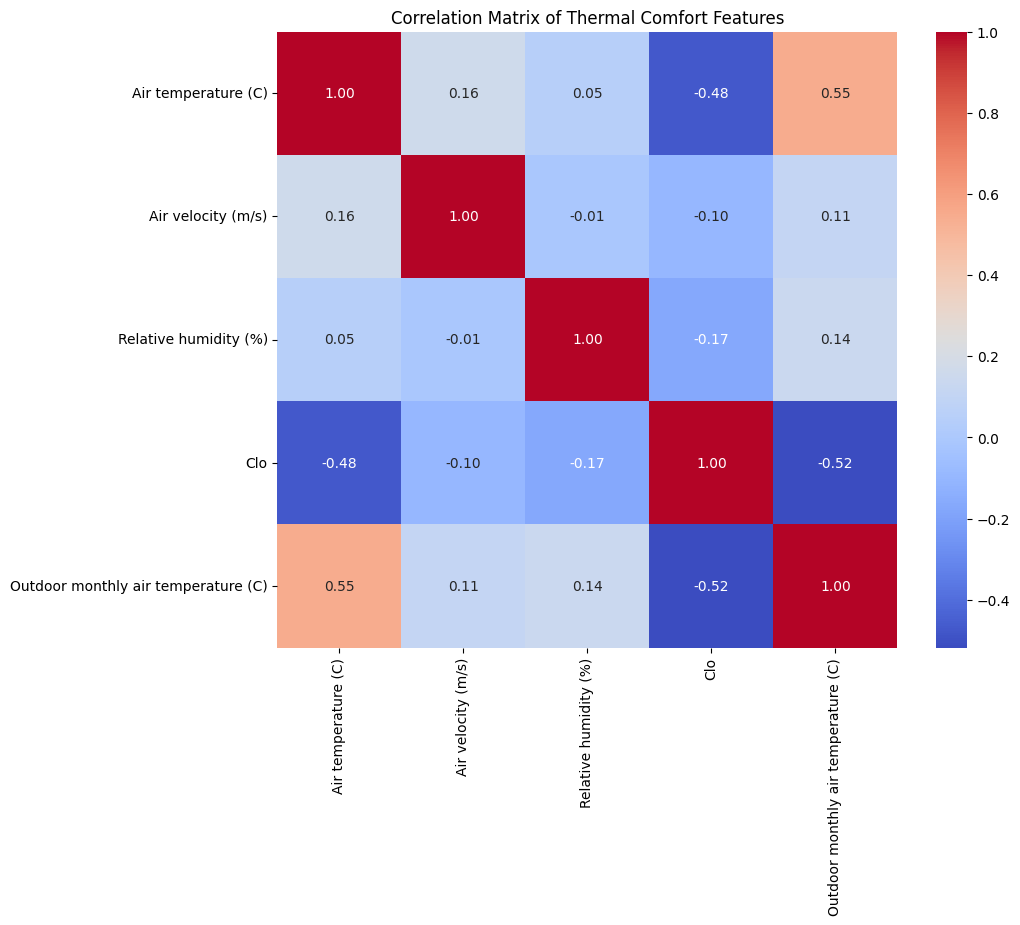

In [0]:
# Calculate the correlation matrix
corr_matrix = data_df.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Thermal Comfort Features')
plt.show()

**Pair Plot:** To see both distributions of individual variables and their relationships

/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


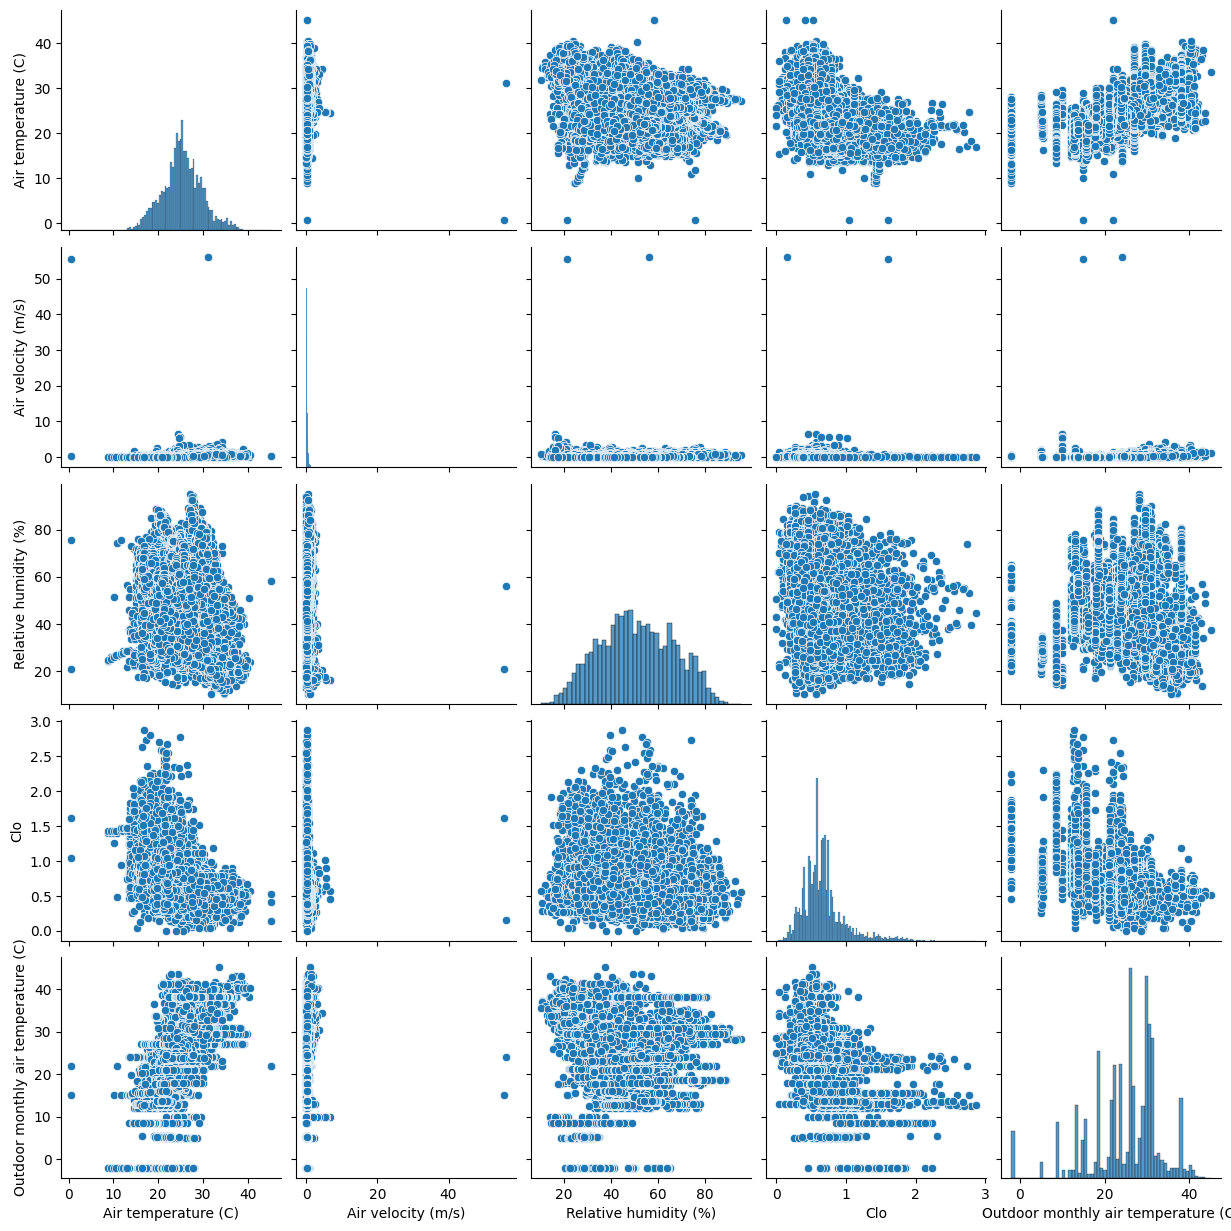

In [0]:
sns.pairplot(data_df)
plt.show()

**Box Plot** Distribution of a numerical variable across different categories.

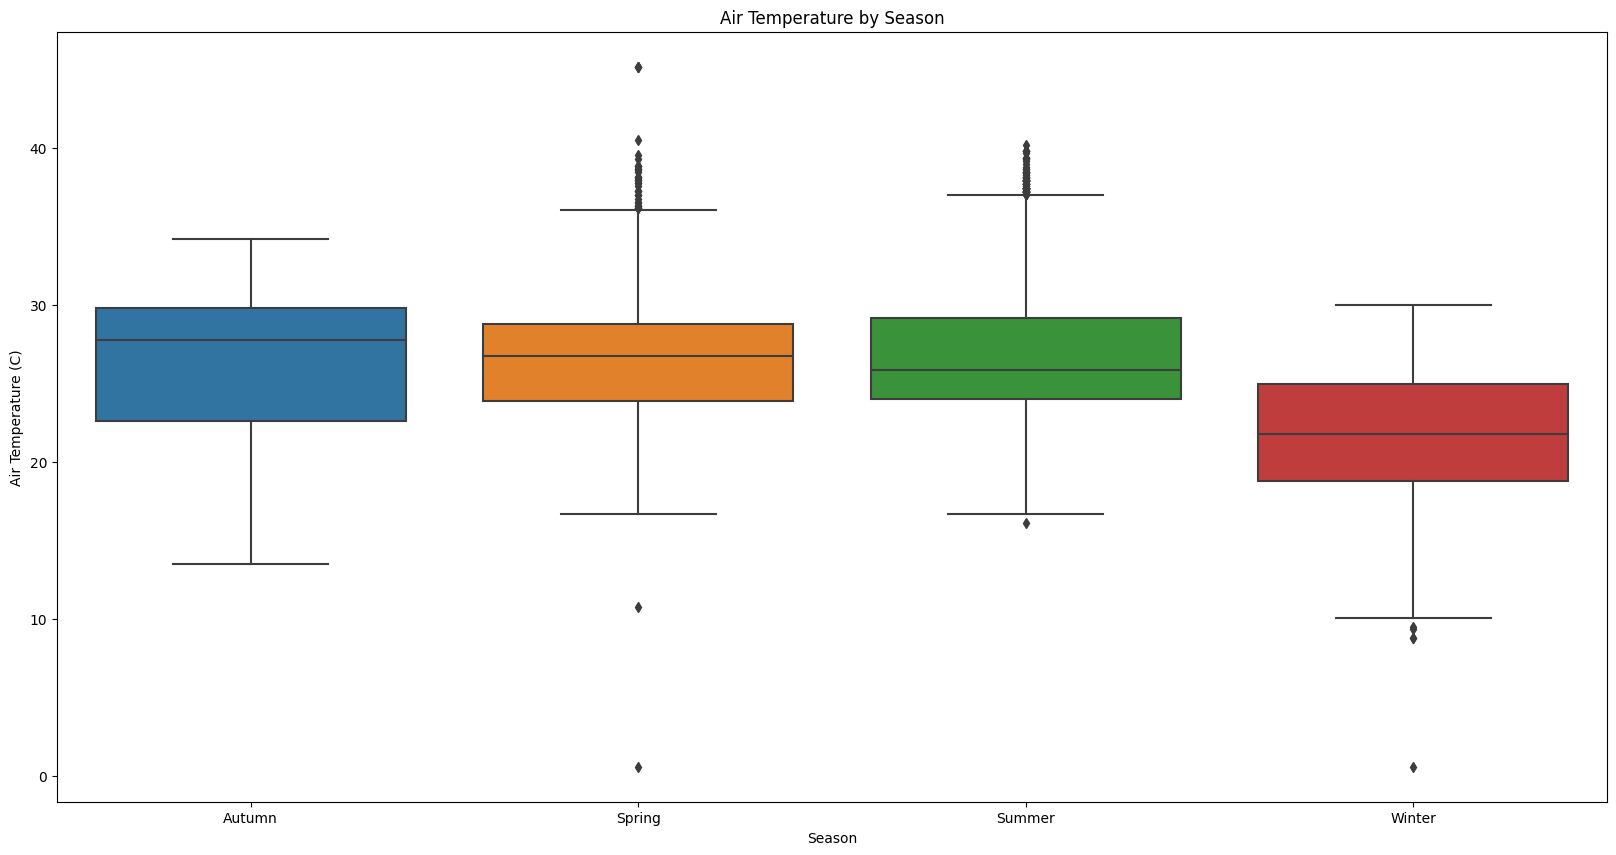

In [0]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='Season', y='Air temperature (C)', data=data_df)
plt.xlabel('Season')
plt.ylabel('Air Temperature (C)')
plt.title('Air Temperature by Season')
plt.show()

**Violin Plots** Density of the data distribution.

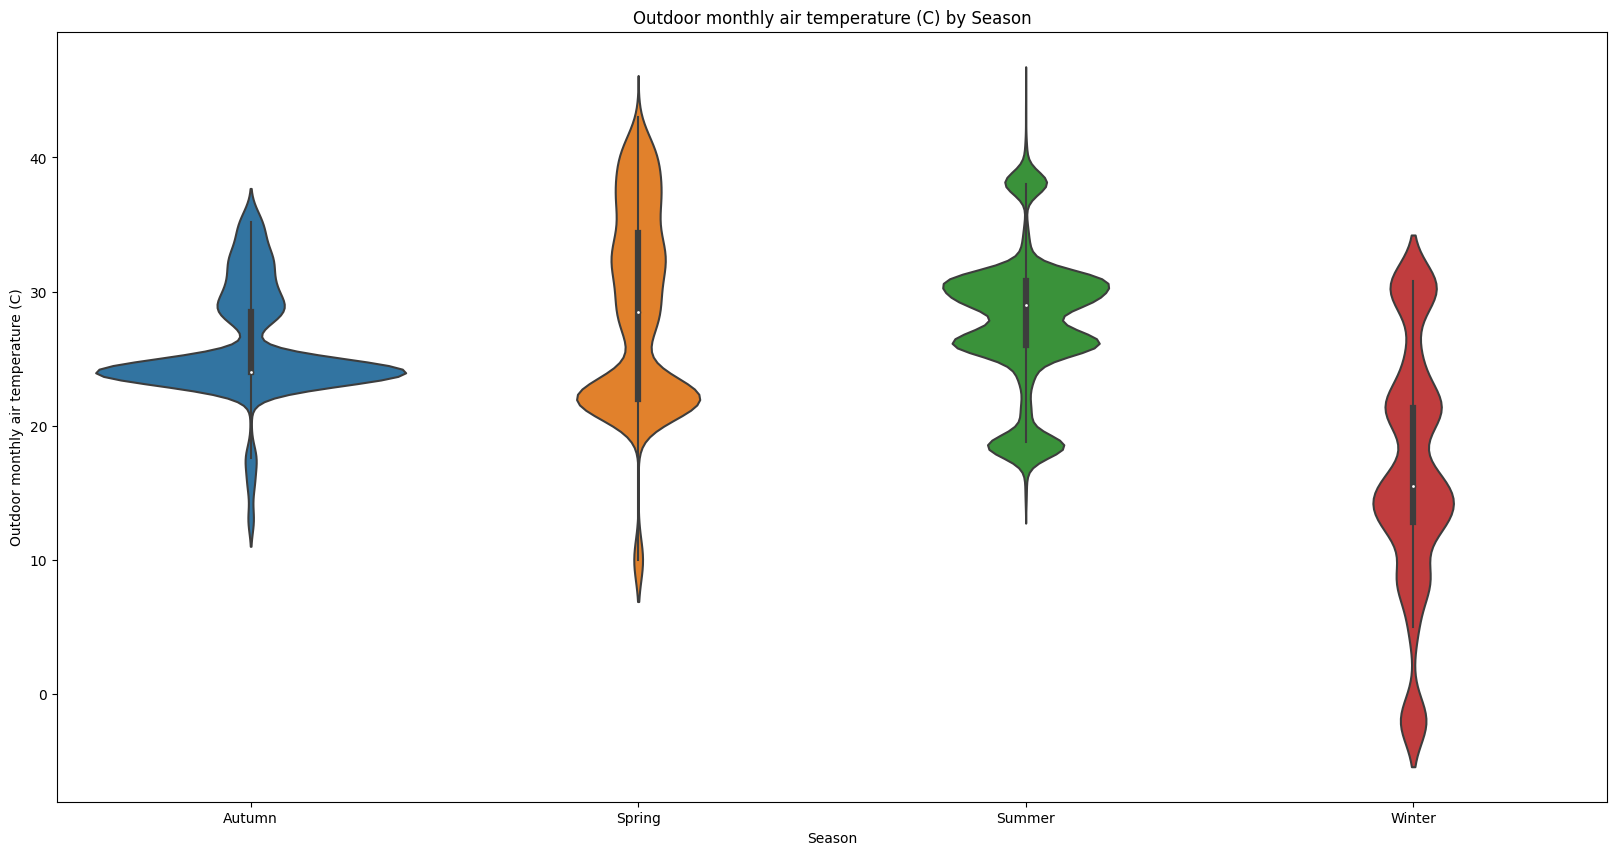

In [0]:
plt.figure(figsize=(20, 10))
sns.violinplot(x='Season', y='Outdoor monthly air temperature (C)', data=data_df)
plt.xlabel('Season')
plt.ylabel('Outdoor monthly air temperature (C)')
plt.title('Outdoor monthly air temperature (C) by Season')
plt.show()

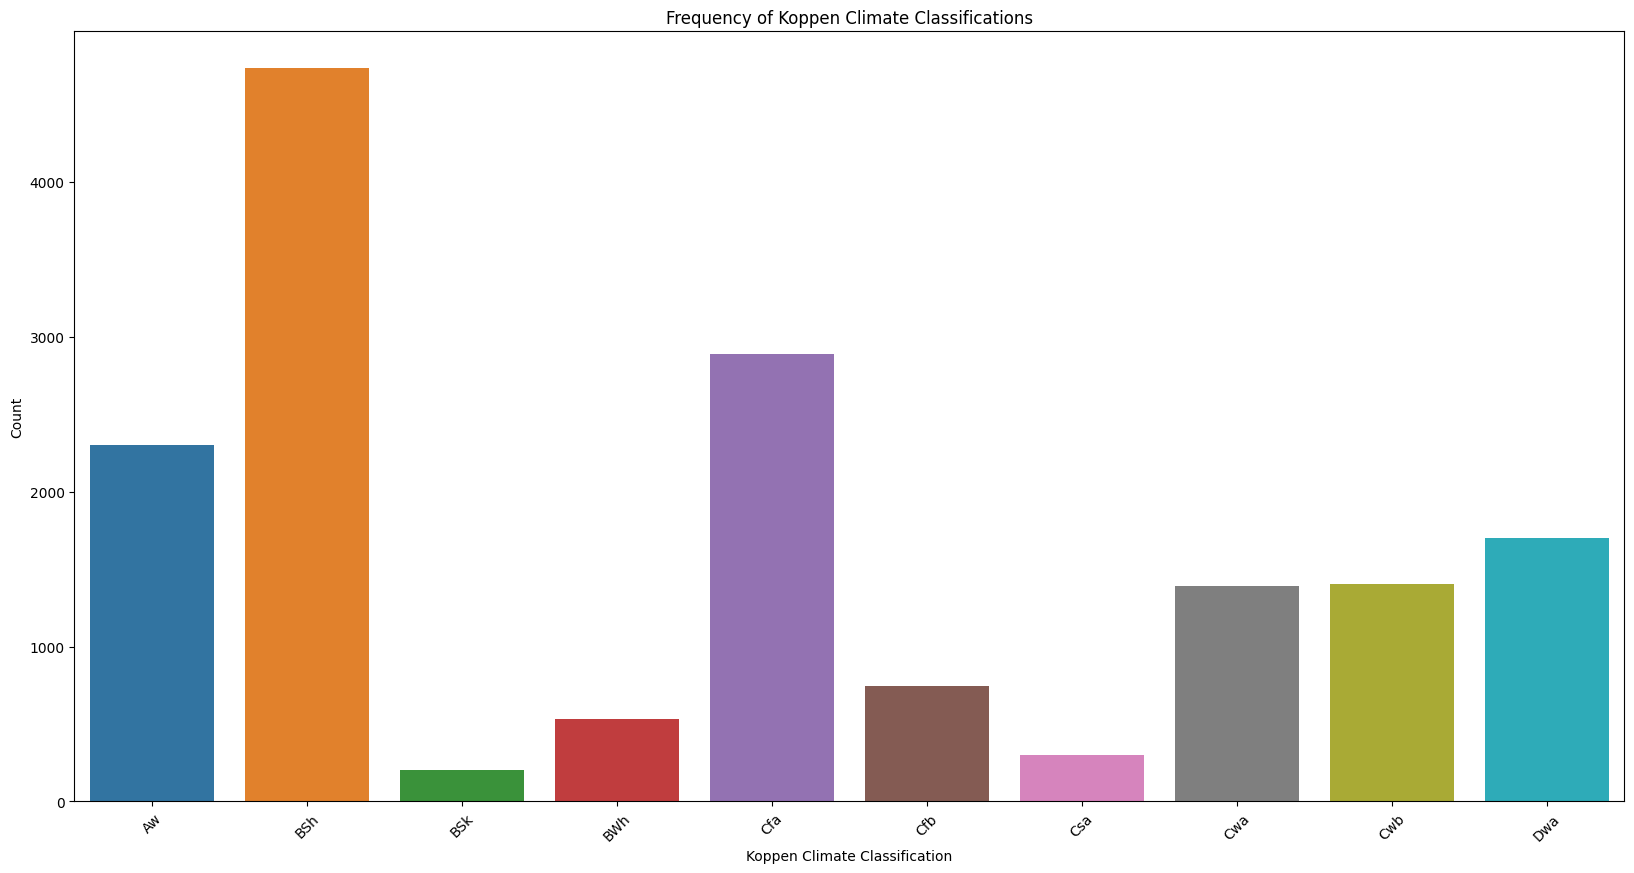

In [0]:
plt.figure(figsize=(20, 10))
sns.countplot(x='Koppen climate classification', data=data_df)
plt.xlabel('Koppen Climate Classification')
plt.ylabel('Count')
plt.title('Frequency of Koppen Climate Classifications')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

### 6. Model Training

In [0]:
Y = data_df['Thermal comfort']

features = ['Air temperature (C)', 'Air velocity (m/s)', 'Relative humidity (%)', 'Clo', 'Met', 
            'Season', 'Koppen climate classification', 'Building type', 'Cooling startegy_building level', 'Outdoor monthly air temperature (C)']

X = data_df[features]

X.describe()

,Air temperature (C),Air velocity (m/s),Relative humidity (%),Clo,Outdoor monthly air temperature (C)
count,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000
mean,25.388728,0.261687,50.913968,0.681518,24.768153
std,4.439810,0.693904,15.763509,0.324204,8.259837
min,0.600000,0.000000,10.300000,0.000000,-2.000000
25%,22.800000,0.060000,39.400000,0.490000,21.300000
50%,25.300000,0.150000,50.100000,0.630000,26.000000
75%,28.100000,0.330000,63.300000,0.780000,30.800000
max,45.200000,56.170000,95.300000,2.870000,45.100000


In [0]:
Y.describe()

count     16209
unique       17
top           5
freq       6230
Name: Thermal comfort, dtype: object

In [0]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16209 entries, 74 to 81750
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Air temperature (C)                  16209 non-null  float64 
 1   Air velocity (m/s)                   16209 non-null  float64 
 2   Relative humidity (%)                16209 non-null  float64 
 3   Clo                                  16209 non-null  float64 
 4   Met                                  16209 non-null  category
 5   Season                               16209 non-null  category
 6   Koppen climate classification        16209 non-null  category
 7   Building type                        16209 non-null  category
 8   Cooling startegy_building level      16209 non-null  category
 9   Outdoor monthly air temperature (C)  16209 non-null  float64 
 10  Thermal comfort                      16209 non-null  category
dtypes: category(6)

In [0]:
print("Shape of X before splitting:", X.shape)
print("Shape of Y before splitting:", Y.shape)

Shape of X before splitting: (16209, 10)
Shape of Y before splitting: (16209,)


In [0]:
# One-hot encode categorical features
categorical_features = ['Met','Season', 'Koppen climate classification', 'Building type', 'Cooling startegy_building level']
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_features = encoder.fit_transform(X[categorical_features])
encoded_df = pd.DataFrame(encoded_features)


/databricks/python/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [0]:
X = X.drop(categorical_features, axis=1)
X_np = X.values
encoded_np = encoded_df.values  

# Horizontally stack the arrays
X_combined = np.hstack((X_np, encoded_np))

# Convert back to a pandas DataFrame (optional)
X = pd.DataFrame(X_combined) 

In [0]:
print("Shape of X before splitting:", X.shape)
print("Shape of Y before splitting:", Y.shape)

Shape of X before splitting: (16209, 51)
Shape of Y before splitting: (16209,)


In [0]:

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize and train the model
#model = RandomForestRegressor(random_state=42)
model = RandomForestClassifier(random_state=42)

model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = model.predict(X_test)

# Evaluate the model
#mse = mean_squared_error(Y_test, Y_pred)
#print(f'Mean Squared Error: {mse}')
# Calculate MAE
# Calculate RMSE manually
#rmse = np.sqrt(mse)

# Calculate MAE
#mae = mean_absolute_error(Y_test, Y_pred)

# Calculate R-squared
#r2 = r2_score(Y_test, Y_pred)

#print(f'RMSE: {rmse}')
#print(f'MAE: {mae}')
#print(f'R-squared: {r2}')



#### 7. Evaluation Matrix

In [0]:

# Assuming Y_test and Y_pred are your true and predicted labels respectively

# Accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(Y_test, Y_pred, average='macro')  # or 'micro', 'weighted'
print(f"Precision: {precision}")

# Recall
recall = recall_score(Y_test, Y_pred, average='macro')  # or 'micro', 'weighted'
print(f"Recall: {recall}")

# F1-score
f1 = f1_score(Y_test, Y_pred, average='macro')  # or 'micro', 'weighted'
print(f"F1-score: {f1}")

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(Y_test, Y_pred)
print("Classification Report:")
print(cr)

Accuracy: 0.5397902529302899
Precision: 0.26713634558451604
Recall: 0.26910204787599834
F1-score: 0.2639454386959716
Confusion Matrix:
[[  7   0  18   0   0   9   0   2   0   0  19  10]
 [  0   0   0   0   0   2   0   0   0   4   0   2]
 [  8   0 272   0   0  45   0  30   0   0 114  12]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0]
 [  8   0  39   0   0 109   0  11   0  24 117  46]
 [  0   0   0   0   0   0   0   0   0   0   0   1]
 [  1   0  10   0   0   4   1  87   0   0 166  90]
 [  0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0  14   0   2   0  42   1   3]
 [  5   0 110   1   0  91   0 111   0   2 740 173]
 [  2   0   2   0   0   7   0  35   0  11 127 493]]
Classification Report:
              precision    recall  f1-score   support

           1       0.23      0.11      0.15        65
         1.5       0.00      0.00      0.00         8
           2       0.60      0.57      0.58       481
         2.2

/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classific